# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import scipy
import numpy as np
import pandas as pd

from joblib import load, dump

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing  import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, ndcg_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

from scipy import sparse

from implicit.als import AlternatingLeastSquares

from catboost import CatBoostClassifier, Pool

/home/mle-user/mle-project/mle-project-sprint-4-v001/.venv_project_sprint_4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [2]:
tracks = pd.read_parquet("data/tracks.parquet")
catalog_names = pd.read_parquet("data/catalog_names.parquet")
interaction = pd.read_parquet("data/interactions.parquet")

In [3]:
#tracks: (1000000, 4)
#catalog_names: (1812471, 3)
#interaction: (222629898, 4)

print(tracks.shape)
print(catalog_names.shape)
print(interaction.shape)

(1000000, 4)
(1812471, 3)
(222629898, 4)


# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [4]:
print('tracks: ')
print(len(tracks['track_id'].unique()))
print(tracks.duplicated(subset=['track_id'], keep=False).value_counts())

print('='*40)
print('catalog_names: ')
print(len(catalog_names['id'].unique()))
print(catalog_names.duplicated(subset=['type', 'name'], keep=False).value_counts())

print('='*40)
print('interaction: ')
print(len(interaction['user_id'].unique()))
print(interaction.duplicated(subset=['user_id', 'track_id', 'started_at'], keep=False).value_counts())

tracks: 
1000000
False    1000000
Name: count, dtype: int64
catalog_names: 
1776697
False    919697
True     892774
Name: count, dtype: int64
interaction: 
1373221
False    222629898
Name: count, dtype: int64


In [5]:
#в catalog_names id некоторых объектов с разными type одинаковые

print('catalog_names: ')
print(len(catalog_names['id'].unique()))
is_duplicated_id_ind = catalog_names['id'][catalog_names.duplicated(subset=['id'], keep=False)].tolist() 
print(len(is_duplicated_id_ind))
catalog_names.loc[catalog_names['id']==12]

catalog_names: 
1776697
70418


,id,type,name
1,12,album,Wild Young Hearts
658728,12,artist,Phil Everly
812317,12,genre,shanson


In [6]:
#распределение по type в catalog_names

catalog_names['type'].value_counts()

type
track     1000000
album      658724
artist     153581
genre         166
Name: count, dtype: int64

In [7]:
#среднее количество записей в interaction на одного user_id

interaction.groupby('user_id').agg({'track_seq': 'count'}).mean()

track_seq    162.12241
dtype: float64

In [8]:
#в tracks.parquet, catalog_names.parquet, interactions.parquet нет ячеек с NaN

print(tracks.isnull().sum())
print(catalog_names.isnull().sum())
print(interaction.isnull().sum())

track_id    0
albums      0
artists     0
genres      0
dtype: int64
id      0
type    0
name    0
dtype: int64
user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64


In [9]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [10]:
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [11]:
#в interaction неверно расставлены индексы - нумерация индексов обновляется для каждого user_id 
print(interaction.info())
interaction.iloc[[24, 25, 26, 27]]

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB
None


,user_id,track_id,track_seq,started_at
24,0,20232119,25,2022-09-14
25,0,20497621,26,2022-09-15
0,1,24417,1,2022-06-11
1,1,108208,2,2022-06-13


In [12]:
interaction.reset_index(drop=True, inplace=True)

In [13]:
interaction

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22
...,...,...,...,...
222629893,1374582,95514767,288,2022-12-29
222629894,1374582,97220301,289,2022-12-29
222629895,1374582,97241171,290,2022-12-29
222629896,1374582,98542641,291,2022-12-29


In [14]:
tracs_by_users = interaction.groupby("track_id").agg(num_users=("user_id", "count")).reset_index()
track_names = catalog_names.query('type=="track"').rename(columns={'id':'track_id'})
tracs_by_users = tracs_by_users.merge(track_names[['track_id', 'name']], on='track_id', how='left')

In [15]:
tracs_by_users.sort_values('num_users', ascending=False)

,track_id,num_users,name
9098,53404,111062,Smells Like Teen Spirit
483876,33311009,106921,Believer
26665,178529,101924,Numb
512157,35505245,99490,I Got Love
829320,65851540,86670,Юность
...,...,...,...
946094,84391078,5,Intro к Mamma Maria
946095,84391079,5,Intro к Koldunya
946096,84391080,5,Intro к Barbie Girl
502881,34766819,5,Reign Fall


In [ ]:
#соберем информацию о прослышанных треков в каждом жанре (~ 12 мин.)

genres_counter = {}

for k, v, in tracks.iterrows():

    genres = v['genres']
    track_id = v['track_id']

    num_users = list(tracs_by_users.loc[tracs_by_users['track_id']==track_id]['num_users'])[0]

    if ((k+1)%100000 == 0):
        print('k=',(k+1),'steps in',len(tracks), end='\r')

    for genre in genres:
        try:
            genres_counter[genre] += num_users
        except KeyError:
            genres_counter[genre] = num_users

In [17]:
genres_by_users = pd.DataFrame.from_dict(genres_counter, orient='index').reset_index().rename(columns={'index':'genre_id', 0:'num_users'})
genre_names = catalog_names.query('type=="genre"').rename(columns={'id':'genre_id'})
genres_by_users = genres_by_users.merge(genre_names[['genre_id', 'name']], on='genre_id', how='left')

In [18]:
#не все жанры есть катологе catalog_names

print(genres_by_users['name'].isnull().value_counts())
nan_genre_id = genres_by_users[genres_by_users['name'].isnull()]['genre_id'].tolist()
print(len(nan_genre_id))
catalog_names.query('type=="genre"').loc[catalog_names['id'].isin(nan_genre_id)]

name
False    143
True      30
Name: count, dtype: int64
30


,id,type,name


In [19]:
#назовем отсутсвующие в каталоге жанры 'other_genre_{id}'

for id in nan_genre_id:
    idx = genres_by_users.loc[genres_by_users['genre_id']==id].index.to_list()[0]
    genres_by_users.at[idx, "name"] = f'other_genre_{id}'
print(genres_by_users['name'].isnull().value_counts())

name
False    173
Name: count, dtype: int64


In [20]:
print(genres_by_users.duplicated(subset=['num_users', 'name'], keep=False).value_counts())

False    173
Name: count, dtype: int64


In [21]:
#tracs_by_users: (1000000, 3)
#genres_by_users: (173, 3)

print(tracs_by_users.shape)
print(genres_by_users.shape)

tracs_by_users.to_parquet("tmp/tracs_by_users.parquet")
genres_by_users.to_parquet("data_artifacts/genres_by_users.parquet")

(1000000, 3)
(173, 3)


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

1. В tracks, catalog_names, interactions ячеек со значением NaN

2. В catalog_names объекты с разными type могут иметь одинаковый id, следует обращать на это внимание

3. Наличие дубликатов в датасетах не очевидно:

    а) catalog_names: треки и альбомы могут как иметь, так и не иметь одинаковые названия, у исполнителей могут быть одинаковые имена, тем не менее одинаковые объекты могут иметь различные id.\
    б) tracs: треки могут иметь более одного исполнителя, относиться к нескольким жанрам и альбомам, id которых сохранены в виде списков в соответствующих колонках. В списках могут значиться id одинаковых объектов из catalog_names, тем не менее даже одинаковый жанр, исполнитель и альбом не означает, что встречен дубликат трека\
    в) interactions: дубликатов по сочетанию пользователя, трека и даты не найдено, однако некоторы треки все-таки могут быть дубликатами.
        
    Будем считать, что существует 1 000 000 уникальных треков, то есть в tracs нет дубликатов, значит, события в interactions также уникальны. Тем не менее к одному треку в tracs нередко относится список альбомов или исполнителей, ссылающийся на объекты с одинаковыми именами в catalog_names, а иногда и альбомы и исполнители разные. Очистка датасета от подобных ошибок требует более детального анализа, который будет проведен при формирования более удобных датасетов для дальнейшего обучения моделей.

4. В interactions индексация обнулялась для каждого user_id (по аналогии со столбцом 'track_seq'), индексация заменена на сквозную.
    
5. Не все id жанров, присутствующие в tracks, есть в каталоге catalog_names.

    Для удобства сразу составим таблицы tracs_by_users и genres_by_users, посчитаем количество пользователей для каждого объекта. Будем считать, что в датасете 173 уникальных жанра, из них 143 есть каталоге catalog_names, еще 30 в каталоге отсутствуют, им были даны имена вида 'other_genre_{id}'.

# === ЭТАП 2 ===

# EDA

In [305]:
#tracks: (1000000, 4)
#interaction: (222629898, 4)
#tracs_by_users: (1000000, 3)
#genres_by_users: (173, 3)

print(tracks.shape)
print(interaction.shape)
print(tracs_by_users.shape)
print(genres_by_users.shape)

(1000000, 4)
(222629898, 4)
(1000000, 3)
(173, 3)


Распределение количества прослушанных треков.

In [6]:
interaction["started_at_month"] = pd.to_datetime(interaction["started_at"]).dt.to_period('M').dt.to_timestamp().dt.date

In [8]:
interactions_by_month = interaction.groupby("started_at_month").agg(events=("started_at", "count"), users=("user_id", "nunique")).reset_index()

In [9]:
interactions_by_month

,started_at_month,events,users
0,2022-01-01,2409541,126224
1,2022-02-01,4533363,227852
2,2022-03-01,7691225,344333
3,2022-04-01,10230295,454378
4,2022-05-01,13613489,569813
5,2022-06-01,16266558,676467
6,2022-07-01,20188819,788369
7,2022-08-01,23919641,892539
8,2022-09-01,26953965,979781
9,2022-10-01,31810464,1056636


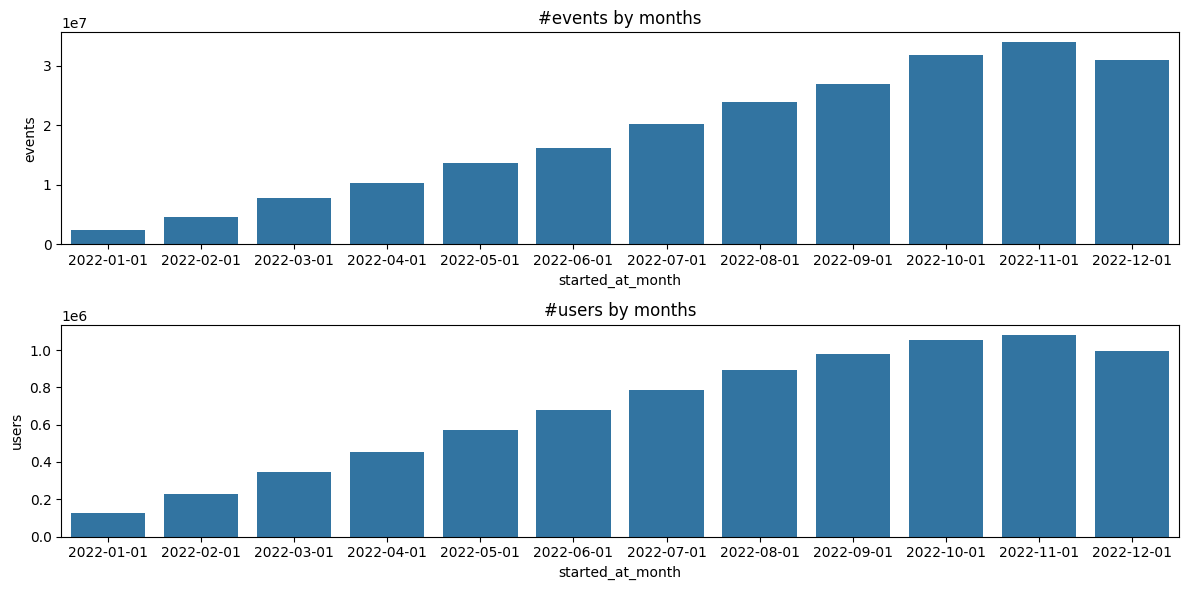

In [10]:
# распределение взаимодействий\пользователей по месяцам

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
sns.barplot(data=interactions_by_month, x="started_at_month", y="events", ax=ax)
ax.set_title("#events by months")

ax = axs[1]
sns.barplot(data=interactions_by_month, x="started_at_month", y="users", ax=ax)
ax.set_title("#users by months")

fig.tight_layout()

Наиболее популярные треки

In [296]:
#топ-5 самых популярных треков

tracs_by_users.sort_values('num_users', ascending=False).head(5)

,track_id,num_users,name
9098,53404,111062,Smells Like Teen Spirit
483876,33311009,106921,Believer
26665,178529,101924,Numb
512157,35505245,99490,I Got Love
829320,65851540,86670,Юность


Наиболее популярные жанры

In [295]:
#топ 5 самых популярных жанров

genres_by_users.sort_values('num_users', ascending=False).head(5)

,genre_id,num_users,name
0,11,55578312,pop
21,75,37799821,rap
3,102,31092013,allrock
75,20,26626241,ruspop
89,3,25303695,rusrap


Треки, которые никто не прослушал

In [15]:
track_ids_in_events = interaction['track_id'].drop_duplicates().to_list()

In [16]:
tracks.loc[~tracks['track_id'].isin(track_ids_in_events)]

,track_id,albums,artists,genres


In [294]:
#треков, которые никто не прослушал, в базе нет
#топ 5 самых непопулярных треков -- минимум 5 слушателей

tracs_by_users.sort_values('num_users', ascending=False).tail(5)

,track_id,num_users,name
946152,84393799,5,Гарри Поттер - детство сердца и беда!
946151,84393776,5,"Что такое Scrum, для чего он нужен и кому подх..."
946139,84392043,5,gogobebe (Inst.)
360338,24149512,5,Соблюдай спокойствие
360396,24154947,5,Window Seat


## Выводы
1. Количество пользователей сервиса и взаимодействия с ним росло до 10.2022, затем установилось примерно на одном уровне (около $10^6$ пользователей и $3\cdot 10^7$ взаимодействий)
2. Самый популярный трек на 12.2022 - Smells Like Teen Spirit, Nirvana (id=53404), за год его прослушали 111062 раз.
3. Самый полпулярный жанр на 12.2022 - pop (id=11), за год песни этого жанра прослушали 55578312 раз.
4. Треков, которые никто за году не прослушал в базе данных нет, каждый трек прослушали как минимум 5 раз

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [22]:
#tracks: (1000000, 4)
#catalog_names: (1812471, 3)
#interaction: (222629898, 4)

#tracs_by_users: (1000000, 3)
#genres_by_users: (173, 3)

print(tracks.shape)
print(catalog_names.shape)
print(interaction.shape)

print(tracs_by_users.shape)
print(genres_by_users.shape)


(1000000, 4)
(1812471, 3)
(222629898, 4)
(1000000, 3)
(173, 3)


In [23]:
#для ускорения разделим каталог по type
artists_names = catalog_names.query('type=="artist"')[['id', 'name']].rename(columns={'id':'artist_id'})
album_names = catalog_names.query('type=="album"')[['id', 'name']].rename(columns={'id':'album_id'})

In [ ]:
#заменим id артистов, альбомов и жанров в tracks на их имена, одновременно удалим дубликаты имен
#(~ 7 мин)

for k, v, in tracks.iterrows():

    genres = v['genres']
    track_id = v['track_id']

    if ((k+1)%100000 == 0):
        print('k=',(k+1),'steps in',len(tracks), end='\r')

    genres_list = []
    for genre in genres:
        ans = list(genres_by_users.loc[genres_by_users['genre_id']==genre]['name'])[0]
        genres_list.append(ans)
    genres_list = list(set(genres_list))

    tracks.at[k, "genres"] = genres_list

In [ ]:
#(~ 8 мин)
for k, v, in tracks.iterrows():

    artists = v['artists']
    track_id = v['track_id']

    if ((k+1)%10000 == 0):
        print('k=',(k+1),'steps in',len(tracks), end='\r')
    artist_list = []
    for artist in artists:
        ans = list(artists_names.loc[artists_names['artist_id']==artist]['name'])[0]
        artist_list.append(ans)
    artist_list = list(set(artist_list))

    tracks.at[k, "artists"] = artist_list

In [26]:
#(~ 16 мин)
for k, v, in tracks.iterrows():

    albums = v['albums'] 
    track_id = v['track_id']

    if ((k+1)%10000 == 0):
        print('k=',(k+1),'steps in',len(tracks), end='\r')

    album_list = []
    for album in albums:
        ans = list(album_names.loc[album_names['album_id']==album]['name'])[0]
        album_list.append(ans)
    album_list = list(set(album_list))

    tracks.at[k, "albums"] = album_list

In [27]:
tracks = tracks.merge(tracs_by_users[['track_id', 'name', 'num_users']], on='track_id', how='left')
tracks = tracks.rename(columns={'track_id':'item_id'})

In [28]:
scaler = MinMaxScaler()
tracks[["num_users_norm"]] = scaler.fit_transform(tracks[["num_users"]])

In [29]:
tracks.to_parquet("data_artifacts/items.parquet")

In [32]:
interaction = interaction.rename(columns={'track_id':'item_id'})

In [33]:
interaction['listened'] = 1

In [34]:
interaction = interaction.merge(tracks[['item_id', 'num_users_norm']], on='item_id', how='left')

In [35]:
interaction.to_parquet("data_artifacts/events.parquet")

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [ ]:
#лучше будет перезапустить ядро jupyter

del interaction
del tracks

del tracs_by_users
del genres_by_users
del album_names
del artists_names


# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [38]:
items = pd.read_parquet("data_artifacts/items.parquet")

In [2]:
events = pd.read_parquet("data_artifacts/events.parquet")

In [40]:
#items: (1000000, 7)
#events: (222629898, 7)

print(items.shape)
print(events.shape)

(1000000, 7)
(222629898, 6)


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [3]:
train_test_global_time_split_date = pd.to_datetime("2022-12-16").date()
train_test_global_time_split_idx = events["started_at"].dt.date < train_test_global_time_split_date

In [4]:
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

In [5]:
# количество пользователей в train, test и всего

users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
users_all = events["user_id"].drop_duplicates()


print( len(users_train), len(users_test), len(users_all))
print(events_train.shape)
print(events_test.shape)

1342566 783525 1373221
(208731252, 6)
(13898646, 6)


In [6]:
#количество пользователей, которые есть и в train и test и "холодных" пользователей, которые есть только в test 

common_users = events_test[events_test["user_id"].isin(users_train)]["user_id"].drop_duplicates()
cold_users = events_test[~events_test["user_id"].isin(users_train)]["user_id"].drop_duplicates()
cold_users=pd.DataFrame(cold_users)
common_users=pd.DataFrame(common_users)

print(len(common_users), len(cold_users))

752870 30655


In [7]:
cold_users.to_parquet("tmp/cold_users.parquet")
common_users.to_parquet("tmp/common_users.parquet")

In [8]:
events_train.to_parquet("tmp/events_train.parquet")
events_test.to_parquet("tmp/events_test.parquet")

# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [2]:
cold_users = pd.read_parquet("tmp/cold_users.parquet")
common_users = pd.read_parquet("tmp/common_users.parquet")
items = pd.read_parquet("data_artifacts/items.parquet")
events_train = pd.read_parquet("tmp/events_train.parquet")
events_test = pd.read_parquet("tmp/events_test.parquet")

In [3]:
#cold_users: (30655, 1)
#common_users: (752870, 1)
#items: (1000000, 7)
#events_train: (208731252, 6)
#events_test: (13898646, 6)

print(cold_users.shape)
print(common_users.shape)
print(items.shape)
print(events_train.shape)
print(events_test.shape)


(30655, 1)
(752870, 1)
(1000000, 7)
(208731252, 6)
(13898646, 6)


In [4]:
top_pop_start_date = pd.to_datetime("2022-09-01").date()
item_popularity = events_train.query("started_at >= @top_pop_start_date")[['user_id', 'item_id', 'num_users_norm']]

In [5]:
del events_train

In [6]:
item_popularity = item_popularity.groupby(["item_id"]).agg(users_top=("user_id", "count")).reset_index()

In [7]:
scaler = MinMaxScaler()
item_popularity[["users_top_norm"]] = scaler.fit_transform(
    item_popularity[["users_top"]])


In [8]:
#выбираем топ 100 самых популярных треков с 2022-09-01 по 2202-12-15

item_popularity = item_popularity.sort_values('users_top_norm', ascending=False)
top_popular = item_popularity.head(100)
top_popular = top_popular.merge(items[['item_id', 'num_users_norm', 'name', 'albums', 'artists', 'genres']], on='item_id', how='left')
display(top_popular.head(5))


,item_id,users_top,users_top_norm,num_users_norm,name,albums,artists,genres
0,60292250,58498,1.000000,0.760564,Blinding Lights,"[The Highlights, After Hours, Blinding Lights]",[The Weeknd],[rnb]
1,65851540,58351,0.997487,0.780365,Юность,[Юность],[Dabro],"[pop, ruspop]"
2,33311009,54978,0.939826,0.962713,Believer,"[Video Game Soundtracks, Tik Tock Songs, Sing ...",[Imagine Dragons],"[rock, allrock]"
3,51241318,52950,0.905158,0.767525,In The End,"[Techno House Hits, 神曲大百科 Vol.1, Tik Tock Esta...","[Mellen Gi, Tommee Profitt, Fleurie]",[rnb]
4,51516485,50861,0.869446,0.705629,bad guy,"[Summer Workout, Female Festival Stars, Sing I...",[Billie Eilish],[indie]


In [9]:
top_popular.to_parquet("recomendation/top_popular.parquet")

# Персональные

Рассчитаем персональные рекомендации.

In [2]:
events = pd.read_parquet("data_artifacts/events.parquet")
items = pd.read_parquet("data_artifacts/items.parquet")

In [ ]:
events_train = pd.read_parquet("tmp/events_train.parquet")
events_test = pd.read_parquet("tmp/events_test.parquet")

In [ ]:
#items: (1000000, 7)
#events: (222629898, 6)
#events_train: (208731252, 6)
#events_test: (13898646, 6)

print(items.shape)
print(events.shape)
print(events_train.shape)
print(events_test.shape)

(1000000, 7)
(222629898, 6)
(208731252, 6)
(13898646, 6)


In [4]:
#перекодируем user_id, чтобы они шли последовательно

user_encoder = LabelEncoder()
user_encoder.fit(events["user_id"])

LabelEncoder()

In [5]:
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])

In [5]:
del events

In [8]:
#перекодируем item_id, чтобы они шли последовательно

item_encoder = LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])

In [7]:
events_train = events_train.merge(items[['item_id', 'item_id_enc']], on='item_id', how='left')

In [9]:
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])
events_test = events_test.merge(items[['item_id', 'item_id_enc']], on='item_id', how='left')

In [8]:
# создаём sparse-матрицу формата CSR вида user_id-item_id 
# 1 -- пользователь прослушал трек, 0 -- пользователь не прослушал трек
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["listened"],
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8)

In [ ]:
# (~ 36 мин)
als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train) 

100%|██████████| 50/50 [36:10<00:00, 43.40s/it]


### Рекомендации для одного пользователя -- проверка рекомендаций

In [23]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations

In [25]:
user_id = events_test['user_id'].sample().iat[0]

print(f"user_id: {user_id}")

print("История (последние события, recent)")
user_history = (
    events_train[events_train['user_id']==user_id]
    .merge(items.set_index("item_id")[["name", "artists", "albums", "genres", 'num_users']], on="item_id")
)
user_history_to_print = user_history[["track_seq", "started_at", "name", "artists", "albums", "genres", "num_users"]].tail(10)
display(user_history_to_print)


print("Персональные рекомендации:")
recomnedation = get_recommendations_als(user_item_matrix_train, als_model, user_id, user_encoder, item_encoder)
recomnedation = recomnedation.merge(items.set_index("item_id")[["name", "artists", "albums", "genres", "num_users"]], on='item_id', how='left')
recomnedation_to_print = recomnedation[["name", "artists", "albums", "genres", "score", "num_users"]]
display(recomnedation_to_print)


user_id: 9174
История (последние события, recent)


,track_seq,started_at,name,artists,albums,genres,num_users
741,742,2022-12-14,Любовь как-нибудь,[Plamenev],[Любовь как-нибудь],[punk],259
742,743,2022-12-14,меня нет,[гречка],[Не за что],"[local-indie, indie]",1706
743,744,2022-12-14,Вор и принцесса,[Fun Mode],[Я буду здесь],[alternative],591
744,745,2022-12-14,Стены цитадели,[Fun Mode],[Я буду здесь],[alternative],519
745,746,2022-12-15,Тёмные земли,[Fun Mode],[Я буду здесь],[alternative],165
746,747,2022-12-15,Воргены,[Fun Mode],[Я буду здесь],[alternative],582
747,748,2022-12-15,Варвар,[Fun Mode],[Я буду здесь],[alternative],1010
748,749,2022-12-15,Слабость,[RasKar],[Разгар],[alternative],6
749,750,2022-12-15,Среди акул,[Мураками],[Среди акул],"[rusrock, allrock]",1764
750,751,2022-12-15,Бездельник,[КИНО],[Кино в Севкабеле],"[rusrock, allrock]",1982


Персональные рекомендации:


,name,artists,albums,genres,score,num_users
0,Прости. Прощай. Привет,[Порнофильмы],[Как в последний раз],[punk],0.673348,27162
1,Я так соскучился,[Порнофильмы],"[В диапазоне между отчаянием и надеждой, Панки...",[punk],0.597494,57911
2,"You're Gonna Go Far, Kid",[The Offspring],"[Pop Goes Punk, Rock Workout 2022, 2000's Rock...",[punk],0.527496,49247
3,Песенка прокрастинатора,[нежность на бумаге],[Рассветы у окна],"[local-indie, indie]",0.517433,19554
4,Spirits,[The Strumbellas],"[Spirits, Hope]","[folkrock, allrock]",0.474390,41872


### Конец рекомендаций для одного пользователя

In [ ]:
users_train = events_train["user_id_enc"].drop_duplicates()
users_test = events_test["user_id_enc"].drop_duplicates()
common_users = events_test[events_test["user_id_enc"].isin(users_train)]["user_id_enc"].drop_duplicates()

user_for_rec= common_users.to_list()

In [ ]:
# получаем персональные рекомендации, для экономии ресурсов возьмем только пользователей, которые есть и в events_train и events_test (common_users)
#(~ 36 мин)

als_recommendations = als_model.recommend(
    user_for_rec, 
    user_item_matrix_train[user_for_rec], 
    filter_already_liked_items=False, N=10)

In [51]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

personal_als = pd.DataFrame({
    "user_id_enc": user_for_rec,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
personal_als = personal_als.explode(["item_id_enc", "score"], ignore_index=True)

personal_als["item_id_enc"] = personal_als["item_id_enc"].astype("int")
personal_als["score"] = personal_als["score"].astype("float")

personal_als["user_id"] = user_encoder.inverse_transform(personal_als["user_id_enc"])
personal_als["item_id"] = item_encoder.inverse_transform(personal_als["item_id_enc"])
personal_als = personal_als.drop(columns=["user_id_enc", "item_id_enc"])
personal_als=personal_als[['user_id', 'item_id', 'score']]

In [52]:
personal_als

,user_id,item_id,score
0,3,35505245,0.426677
1,3,45499814,0.321614
2,3,33311009,0.297880
3,3,49961817,0.288920
4,3,54798445,0.265733
...,...,...,...
7528695,1374582,83063895,0.210580
7528696,1374582,69459326,0.206378
7528697,1374582,67538121,0.199272
7528698,1374582,62352385,0.179136


In [53]:
personal_als.to_parquet("recomendation/personal_als.parquet")

In [5]:
#als_model = load('model/als_model.joblib')

dump(als_model, 'model/als_model.joblib', compress=9)


['model/als_model.joblib']

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [2]:
als_model = load('model/als_model.joblib')

In [4]:
events_train = pd.read_parquet("tmp/events_train.parquet")

In [3]:
genres = pd.read_parquet("data_artifacts/genres_by_users.parquet")
items = pd.read_parquet("data_artifacts/items.parquet")
common_users= pd.read_parquet("tmp/common_users.parquet")

In [ ]:
#genres: (173, 3)
#items: (1000000, 7)
#common_users: (752870, 1)
#events_train: (208731252, 6)

print(genres.shape)
print(items.shape)
print(common_users.shape)
print(events_train.shape)
print(als_model)

(173, 3)
(1000000, 7)
(752870, 1)
(208731252, 6)


In [6]:
scaler = MinMaxScaler()
genres[["score"]] = scaler.fit_transform(genres[["num_users"]])

genre_encoder = LabelEncoder()
genre_encoder.fit(genres["genre_id"])
genres["genre_id_enc"] = genre_encoder.transform(genres["genre_id"])
genres = genres.sort_values(by="genre_id_enc")



In [7]:
item_encoder = LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
items = items.sort_values(by="item_id_enc")

In [8]:
def get_item2genre_matrix(genres, items):

    #составляем матрицу items-genres: 1 - у трека есть такой жанр, 0 - у трека нет такого жанра.

    genre_names_to_id = genres.reset_index().set_index("name")["genre_id_enc"].to_dict()
       
    genres_csr_data = []
    genres_csr_row_idx = []
    genres_csr_col_idx = []
    
    for item_idx, (k, v) in enumerate(items.iterrows()):
           
        if v["genres"] is None:
            continue
        for genre_name in v["genres"]:
            
            genre_idx = genre_names_to_id[genre_name]
            genres_csr_data.append(int(1))
            genres_csr_row_idx.append(item_idx)
            genres_csr_col_idx.append(genre_idx)
     

    genres_csr = scipy.sparse.csr_matrix((genres_csr_data, (genres_csr_row_idx, genres_csr_col_idx)), shape=(len(items), len(genres)) )
    genres_csr = sklearn.preprocessing.normalize(genres_csr, norm='l1', axis=1)
    
    return genres_csr
    

In [9]:
all_items_genres_csr = get_item2genre_matrix(genres, items)

#### Рекомендации для одного пользователя -- проверка -- сравнение косинусного сходства и евклидового расстояния

In [47]:
def get_content_recomendation(user_id, events_train, items, all_items_genres_csr, top_k=5):

    user_events = events_train.query("user_id == @user_id")[["item_id", "listened"]]
    user_items = items[items["item_id"].isin(user_events["item_id"])]

    user_items_genres_csr = get_item2genre_matrix(genres, user_items)
    
    user_ratings = user_events["listened"].to_numpy()
    user_ratings = np.expand_dims(user_ratings, axis=1)

    user_items_genres_weighted = user_items_genres_csr.multiply(user_ratings)
    user_genres_scores = np.asarray(user_items_genres_weighted.mean(axis=0))

    user_genres = genres.copy()
    user_genres["score"] = np.ravel(user_genres_scores)
    user_genres = user_genres[user_genres["score"] > 0].sort_values(by=["score"], ascending=False)



    print(f"user_id: {user_id}")
    print("История (последние события, recent)")
    user_history = (events_train.query("user_id == @user_id")
                    .merge(items.set_index("item_id")[["name", "albums", "artists", "genres", 'num_users']], on="item_id"))
    
    user_history_to_print = user_history[["name", "albums", "artists", "genres", "num_users", "started_at"]].tail(5)
    display(user_history_to_print)


    print(f'Топ {top_k} популярных жанров для user_id = {user_id}')
    display(user_genres.head(top_k))

    similarity_scores_cos = cosine_similarity(all_items_genres_csr, user_genres_scores)
    similarity_scores_euc = euclidean_distances(all_items_genres_csr, user_genres_scores)

    similarity_scores_cos = similarity_scores_cos.flatten()
    similarity_scores_euc = similarity_scores_euc.flatten()

    top_k_indices_cos = np.argsort(similarity_scores_cos)[:top_k]
    top_k_indices_euc = np.argsort(similarity_scores_euc)[:top_k]
    ans_cos = items[['item_id', 'name' ,'albums', 'artists', 'genres', 'num_users']].iloc[top_k_indices_cos.tolist()]
    ans_euc = items[['item_id', 'name' ,'albums', 'artists', 'genres', 'num_users']].iloc[top_k_indices_euc.tolist()]

    print(f'Топ {top_k} похожих треков для user_id = {user_id} (косинусное сходство)')
    display(ans_cos)

    print(f'Топ {top_k} похожих треков для user_id = {user_id} (евклидово расстояние)')
    display(ans_euc)



In [48]:
user_id = 5
get_content_recomendation(user_id, events_train, items, all_items_genres_csr)

user_id: 5
История (последние события, recent)


,name,albums,artists,genres,num_users,started_at
67,Любовь,"[Вера, надежда, любовь]",[Кукрыниксы],"[rusrock, allrock]",2736,2022-11-27
68,Шалавы,"[Шалавы, Песни нашего двора, Аккорды души, Про...",[Андрей Алексин],"[rusrock, allrock]",12617,2022-11-28
69,Вахтёрам,[Family бізнес],[Бумбокс],"[allrock, ukrrock]",51640,2022-12-06
70,Believer,"[Sunbathing Soundtrack, Feel Good Mornings, Oh...",[Imagine Dragons],"[allrock, rock]",106921,2022-12-07
71,Серо-жёлтая весна,[Как правило – без правил!],[Александр Пушной],"[rusrock, allrock]",4766,2022-12-15


Топ 5 популярных жанров для user_id = 5


,genre_id,num_users,name,score,genre_id_enc
3,102,31092013,allrock,0.436343,95
88,2,13166147,rusrock,0.215278,1
4,14,12772644,rock,0.186343,13
8,13,10111562,alternative,0.041667,12
0,11,55578312,pop,0.032407,10


Топ 5 похожих треков для user_id = 5 (косинусное сходство)


,item_id,name,albums,artists,genres,num_users
755953,57705810,Честь,[Вайнахская музыка],[Ризавди Исмаилов],"[caucasian, folk]",108
51,559,Mare,[THE E.N.D. (THE ENERGY NEVER DIES)],[Black Eyed Peas],[electronics],23
59,594,Peace Piece,"[Jazz Legends, Everybody Digs Bill Evans, Jazz...",[Bill Evans],"[jazz, other_genre_162]",8
60,599,Time Remembered,[The Definitive Bill Evans on Riverside and Fa...,"[Bill Evans, Zoot Sims, Jim Hall, Ron Carter, ...",[jazz],6
63,649,To The Dregs,[Wavvves],[Wavves],[indie],5


Топ 5 похожих треков для user_id = 5 (евклидово расстояние)


,item_id,name,albums,artists,genres,num_users
900781,75332064,Девушка из харчевни,"[Песни Новеллы Матвеевой, Лучшие песни]",[Сегодня в Мире],"[rusrock, allrock, rock]",40
897539,74744601,Как Вячеслав,"[Как Вячеслав, Очевидное и невероятное]",[Радар],"[rusrock, allrock, rock]",9
885567,73052008,Панк-рок,"[Панк-рок, Очевидное и невероятное]","[Радар, Константин Кинчев]","[rusrock, allrock, rock]",144
882468,72675554,Деменция,"[Деменция прекокс и бродяжничество, Деменция]","[Убей меня, Эйс!]","[rusrock, allrock, rock]",26
791713,61697566,Останемся здесь,[Останемся здесь],[Lights Out!],"[rusrock, allrock, rock]",5


#### Конец рекомендаций для одного пользователя

In [11]:
events_train = events_train.merge(items.set_index("item_id")[['item_id_enc']], on="item_id")
train_item_ids_enc = events_train['item_id_enc'].unique()

In [ ]:
# ~ 67 мин
max_similar_items = 10

similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

In [14]:
# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "item_id_enc": train_item_ids_enc,
    "sim_item_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()})

similar_items = similar_items.explode(["sim_item_id_enc", "score"], ignore_index=True)

similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

similar_items["item_id_1"] = item_encoder.inverse_transform(similar_items["item_id_enc"])
similar_items["item_id_2"] = item_encoder.inverse_transform(similar_items["sim_item_id_enc"])
similar_items = similar_items.drop(columns=["item_id_enc", "sim_item_id_enc"])

similar_items = similar_items.query("item_id_1 != item_id_2")

In [19]:
def print_sim_items(item_id, similar_items):

    item_columns_to_use = ['item_id', 'name' ,'albums', 'artists', 'genres', 'num_users']
    
    item_id_1 = items.query("item_id == @item_id")[item_columns_to_use]
    display(item_id_1)
    
    si = similar_items.query("item_id_1 == @item_id")
    si = si.merge(items[item_columns_to_use].set_index("item_id"), left_on="item_id_2", right_index=True)
    display(si)

In [79]:
print_sim_items(575039, similar_items)

,item_id,name,albums,artists,genres,num_users
59472,575039,Улица роз,[Герой асфальта],[Ария],"[metal, classicmetal]",11731


,score,item_id_1,item_id_2,name,albums,artists,genres,num_users
271811,0.983079,575039,575073,Возьми моё сердце,[Ночь короче дня],[Ария],"[metal, classicmetal]",14660
271812,0.951094,575039,575082,"Встань, страх преодолей",[С кем ты?],[Ария],"[metal, classicmetal]",8227
271813,0.948064,575039,575075,Ангельская пыль,[Ночь короче дня],[Ария],"[metal, classicmetal]",7408
271814,0.941236,575039,592713,Там высоко,[Беспечный ангел],[Ария],"[metal, classicmetal]",9328
271815,0.940295,575039,575080,Воля и разум,[С кем ты?],[Ария],"[metal, classicmetal]",5733
271816,0.938952,575039,575042,Герой асфальта,[Герой асфальта],[Ария],"[metal, classicmetal]",5197
271817,0.932172,575039,592657,Штиль,[Химера],[Ария],"[metal, classicmetal]",25644
271818,0.921383,575039,575031,Грязь,[Генератор зла],[Ария],"[metal, classicmetal]",6808
271819,0.916692,575039,592661,Осколок льда,[Химера],[Ария],"[metal, classicmetal]",24512
271820,0.915875,575039,592649,Потерянный рай,[2000 и одна ночь],[Ария],"[metal, classicmetal]",20518


In [9]:
sparse.save_npz("tmp/all_items_genres_csr.npz", all_items_genres_csr)

In [17]:
similar_items.to_parquet("data_artifacts/similar_items.parquet") 

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [2]:
genres = pd.read_parquet("data_artifacts/genres_by_users.parquet")
items = pd.read_parquet("data_artifacts/items.parquet")

In [3]:
events = pd.read_parquet("data_artifacts/events.parquet")

In [47]:
#genres: (173, 3)
#items: (1000000, 7)
#events: (222629898, 6)

print(genres.shape)
print(items.shape)
print(events.shape)

(173, 3)
(1000000, 7)
(222629898, 6)


In [ ]:
scaler = MinMaxScaler()
genres[["score"]] = scaler.fit_transform(genres[["num_users"]])

genre_encoder = LabelEncoder()
genre_encoder.fit(genres["genre_id"])
genres["genre_id_enc"] = genre_encoder.transform(genres["genre_id"])
genres = genres.sort_values(by="score", ascending=False)

In [ ]:
# ~ 4.40 мин
for (k, v) in items.iterrows():
    
    item_id = v['item_id']
    num_albums = len(v['albums'])

    genre_score = []
    for genre_name in v["genres"]:
        ans = genres[genres['name']==genre_name]['score'].to_list()[0]
        genre_score.append(ans)
    
    genre_score_mean = np.mean(genre_score)
    items.at[k, "num_albums"] = int(num_albums)
    items.at[k, "genre_score_mean"] = genre_score_mean

items["num_albums"] = items["num_albums"].astype("int")
items["genre_score_mean"] = items["genre_score_mean"].astype("float")

c:\qqy\sci\py-project\mle-project\yandex_ML\mle-recsys-start\env-recsys-start\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\qqy\sci\py-project\mle-project\yandex_ML\mle-recsys-start\env-recsys-start\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [41]:
item_encoder = LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
items = items.sort_values(by="item_id_enc")

In [15]:
user_features = events.groupby("user_id").agg(
    listening_month = ("started_at", lambda x: (x.max()-x.min()).days/30),
    tracks_listened=("item_id", "count"))

In [17]:
user_features["tracks_per_month"] = user_features["tracks_listened"] / user_features["listening_month"]

In [43]:
items.to_parquet("data_artifacts/items_with_features.parquet") 

In [19]:
user_features.to_parquet("data_artifacts/user_features.parquet") 

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [2]:
events_test = pd.read_parquet("tmp/events_test.parquet")
personal_als = pd.read_parquet("recomendation/personal_als.parquet")

In [3]:
items_with_features= pd.read_parquet("data_artifacts/items_with_features.parquet") 
user_features= pd.read_parquet("data_artifacts/user_features.parquet")

In [4]:
#events_test: (13898646, 6)
#personal_als: (7835250, 4)
#items_with_features: (1000000, 10)
#user_features: (1373221, 3)

print(events_test.shape)
print(personal_als.shape)
print(items_with_features.shape)
print(user_features.shape)

(13898646, 6)
(7835250, 4)
(1000000, 10)
(1373221, 3)


In [5]:
split_date_for_labels = pd.to_datetime("2022-12-21")

split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels

events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()

In [6]:
candidates = personal_als[["user_id", "item_id", "score"]].rename(columns={"score": "als_score"})

In [7]:
# добавляем таргет к кандидатам со значением:
# — 1 для тех item_id, которые пользователь прослушал
# — 0, для всех остальных 

events_labels["target"] = 1
candidates = candidates.merge(events_labels[["target", "user_id", "item_id"]], on=["user_id", "item_id"], how="left")
candidates["target"] = candidates["target"].fillna(0).astype("int")

In [8]:
# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

In [9]:
# для каждого пользователя оставляем только 3 негативных примера

negatives_per_user = 3
candidates_for_train = pd.concat([
    candidates_to_sample.query("target == 1"),
    candidates_to_sample.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=0))
    ])

C:\Users\qqy_i\AppData\Local\Temp\ipykernel_15012\2944259214.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(negatives_per_user, random_state=0))


In [13]:
candidates_to_rank = personal_als[["user_id", "item_id", "score"]].rename(columns={"score": "als_score"})

In [10]:
candidates_for_train = candidates_for_train.merge(items_with_features[["num_albums", "genre_score_mean", "item_id"]],on=["item_id"], how="left")
candidates_for_train = candidates_for_train.merge(user_features, on="user_id", how="left")

In [14]:
candidates_to_rank = candidates_to_rank.merge(items_with_features[["num_albums", "genre_score_mean", "item_id"]],on=["item_id"], how="left")
candidates_to_rank = candidates_to_rank.merge(user_features, on="user_id", how="left")

In [12]:
features = ['als_score', 'num_albums', 'genre_score_mean', 'listening_month', 'tracks_listened', 'tracks_per_month']
target = 'target'

train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0,
)

cb_model.fit(train_data)

0:	learn: 0.6708856	total: 179ms	remaining: 2m 58s
100:	learn: 0.5527206	total: 1.14s	remaining: 10.1s
200:	learn: 0.5405363	total: 2.08s	remaining: 8.27s
300:	learn: 0.5344998	total: 3.02s	remaining: 7s
400:	learn: 0.5298036	total: 3.94s	remaining: 5.89s
500:	learn: 0.5259817	total: 4.87s	remaining: 4.85s
600:	learn: 0.5230821	total: 5.82s	remaining: 3.86s
700:	learn: 0.5203918	total: 6.78s	remaining: 2.89s
800:	learn: 0.5178646	total: 7.85s	remaining: 1.95s
900:	learn: 0.5154420	total: 8.99s	remaining: 988ms
999:	learn: 0.5133191	total: 10.1s	remaining: 0us


In [15]:
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["cb_score"] = predictions[:, 1]

In [17]:
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

max_recommendations_per_user = 10
final_recommendations = candidates_to_rank.query("rank <= @max_recommendations_per_user")

In [20]:
feature_importance = pd.DataFrame(cb_model.get_feature_importance(), 
    index=features, 
    columns=["fi"])

feature_importance= feature_importance.sort_values('fi', ascending=False)
print(feature_importance)

                         fi
genre_score_mean  36.459535
num_albums        34.435808
als_score         13.738880
listening_month    7.045092
tracks_listened    4.931646
tracks_per_month   3.389039


In [21]:
final_recommendations.to_parquet("recomendation/recommendations.parquet")

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [24]:
events_train = pd.read_parquet("tmp/events_train.parquet")
events_test = pd.read_parquet("tmp/events_test.parquet")

In [26]:
items = pd.read_parquet("data_artifacts/items.parquet")

In [ ]:
cold_users= pd.read_parquet("tmp/cold_users.parquet")
common_users= pd.read_parquet("tmp/common_users.parquet")
top_popular= pd.read_parquet("recomendation/top_popular.parquet")
personal_als = pd.read_parquet("recomendation/personal_als.parquet")
recommendations= pd.read_parquet("recomendation/recommendations.parquet")

In [ ]:
#items: (1000000, 7)
#events_train: (208731252, 7)
#events_test: (13898646, 7)
#cold_users: (30655, 1)
#common_users: (752870, 1)
#top_popular: (100, 8)
#personal_als: (7835250, 4)
#recommendations: (7835250, 10)

print(items.shape)
print(events_train.shape)
print(events_test.shape)
print(cold_users.shape)
print(common_users.shape)
print(top_popular.shape)
print(personal_als.shape)
print(recommendations.shape)

(1000000, 7)
(208731252, 6)
(13898646, 6)
(30655, 1)
(752870, 1)
(100, 8)
(7835250, 4)
(7835250, 10)


In [34]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common


def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()


    return precision, recall

In [ ]:
split_date_for_labels = pd.to_datetime("2022-12-21")

split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels

events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()

### Оценка рекомендаций ТОП 100

In [25]:
#даем рекомендации "холодным" пользователям, основывая на топ 100 популярных треков в период с 2022-09-01 по 2202-12-15
#оценим качество рекомендаций

cold_users_events =  events_test[['user_id', 'item_id']]\
                    .loc[events_test["user_id"].isin(cold_users['user_id'].to_list())]\
                    .merge(top_popular[["item_id", "users_top_norm", "num_users_norm"]], on="item_id", how="left")

cold_user_items_no_rating_idx = cold_users_events["users_top_norm"].isnull()
cold_user_recs = cold_users_events[~cold_user_items_no_rating_idx][["user_id", "item_id", "users_top_norm", "num_users_norm"]]
 
display(cold_user_recs.head(5))


rmse = np.sqrt(mean_squared_error(cold_user_recs["num_users_norm"], cold_user_recs["users_top_norm"]))
mae = mean_absolute_error(cold_user_recs["num_users_norm"], cold_user_recs["users_top_norm"])
cov_items = len(cold_user_recs['item_id'].unique())/len(items)

cold_users_hit_ratio = cold_users_events.groupby("user_id").agg(hits=("users_top_norm", lambda x: (~x.isnull()).mean()))

print(f'Метрики рекомендаций для "холодных" пользователей : rmse = {round(rmse, 2)}, mae = {round(mae, 2)}')
print(f"Доля пользователей без релевантных рекомендаций: {(cold_users_hit_ratio == 0).mean().iat[0]:.2f}")
print(f"Среднее покрытие пользователей: {cold_users_hit_ratio[cold_users_hit_ratio != 0].mean().iat[0]:.2f}")


,user_id,item_id,users_top_norm,num_users_norm
56,83,57921154,0.799990,0.672880
100,171,54400255,0.582423,0.467301
106,175,39307896,0.446433,0.468381
115,175,50834580,0.589671,0.531808
141,440,2758009,0.497889,0.703927


Метрики рекомендаций для "холодных" пользователей : rmse = 0.15, mae = 0.12
Доля пользователей без релевантных рекомендаций: 0.47
Среднее покрытие пользователей: 0.11


In [27]:
#даем рекомендации для старых пользователям (есть в events_train и events_test), основывая на топ 100 популярных треков в период с 2022-09-01 по 2202-12-15
#оценим качество рекомендаций

common_users_events =  events_test[['user_id', 'item_id']]\
                    .loc[events_test["user_id"].isin(common_users['user_id'].to_list())]\
                    .merge(top_popular[["item_id", "users_top_norm", "num_users_norm"]], on="item_id", how="left")

common_user_items_no_rating_idx = common_users_events["users_top_norm"].isnull()
common_user_recs = common_users_events[~common_user_items_no_rating_idx][["user_id", "item_id", "users_top_norm", "num_users_norm"]]
 
display(common_user_recs.head(5))

rmse = np.sqrt(mean_squared_error(common_user_recs["num_users_norm"], common_user_recs["users_top_norm"]))
mae = mean_absolute_error(common_user_recs["num_users_norm"], common_user_recs["users_top_norm"])
cov_items = len(common_user_recs['item_id'].unique())/len(items)

common_users_hit_ratio = common_users_events.groupby("user_id").agg(hits=("users_top_norm", lambda x: (~x.isnull()).mean()))

print(f'Метрики рекомендаций для "холодных" пользователей : rmse = {round(rmse, 2)}, mae = {round(mae, 2)}')
print(f"Доля пользователей без релевантных рекомендаций: {(common_users_hit_ratio == 0).mean().iat[0]:.2f}")
print(f"Среднее покрытие пользователей: {common_users_hit_ratio[common_users_hit_ratio != 0].mean().iat[0]:.2f}")

,user_id,item_id,users_top_norm,num_users_norm
0,3,78194999,0.479717,0.356078
29,10,45499814,0.839205,0.763059
31,10,49125069,0.486093,0.424593
84,15,57921154,0.799990,0.672880
85,15,65851540,0.997487,0.780365


Метрики рекомендаций для "холодных" пользователей : rmse = 0.13, mae = 0.12
Доля пользователей без релевантных рекомендаций: 0.72
Среднее покрытие пользователей: 0.20


### Конец оценки рекомендаций ТОП 100

### Оценка персональных рекомендаций (ALS)

In [51]:
events_train = pd.read_parquet("tmp/events_train.parquet")
events_test = pd.read_parquet("tmp/events_test.parquet")
personal_als= pd.read_parquet("recomendation/personal_als.parquet")

In [ ]:
#events_train: (208731252, 6)
#events_test: (13898646, 6)
#personal_als: (7835250, 4)

print(events_train.shape)
print(events_test.shape)
print(personal_als.shape)

(208731252, 6)
(13898646, 6)
(7835250, 4)


In [ ]:
def compute_ndcg(rating: pd.Series, score: pd.Series, k):

    """ подсчёт ndcg
    rating: истинные оценки
    score: оценки модели
    k: количество айтемов (по убыванию score) для оценки, остальные - отбрасываются
    """
    
    # если кол-во объектов меньше 2, то NDCG - не определена
    if len(rating) < 2:
        return np.nan

    ndcg = ndcg_score(np.asarray([rating.to_numpy()]), np.asarray([score.to_numpy()]), k=k)

    return ndcg

personal_als = (personal_als.merge(events_test[["user_id", "item_id", "num_users_norm"]]\
                .rename(columns={"num_users_norm": "rating_test"}), on=["user_id","item_id"], how="left"))

rating_test_idx = ~personal_als["rating_test"].isnull()
ndcg_at_5_scores = personal_als[rating_test_idx].groupby("user_id").apply(lambda x: compute_ndcg(x["rating_test"], x["score"], k=5), include_groups=False)

ndcg_at_5_mean = ndcg_at_5_scores.mean()
print(f'ndcg@5 = {round(ndcg_at_5_mean, 2)}')

In [62]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).infer_objects(copy=False).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).infer_objects(copy=False).mean()


    return precision, recall

In [64]:
events_recs_for_binary_metrics = process_events_recs_for_binary_metrics(events_train, events_test, personal_als, top_k=5)
precision, recall=compute_cls_metrics(events_recs_for_binary_metrics)

Common users: 783525


C:\Users\qqy_i\AppData\Local\Temp\ipykernel_13284\1697557694.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_recs_common["gt"] = events_recs_common["gt"].fillna(False).infer_objects(copy=False)


In [65]:

print(f'precision = {round(precision, 4)}, recall= {round(recall, 4)}')


precision = 0.0068, recall= 0.0055


### Конец оценки персональных рекомендаций (ALS)

### Оценка качества итоговых рекомендаций

In [31]:
events_inference = pd.concat([events_train, events_labels])
events_inference = events_inference[events_inference["user_id"].isin(events_test_2["user_id"].drop_duplicates())]

In [35]:
cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    recommendations.rename(columns={"cb_score": "score"}), 
    top_k=5)

cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

Common users: 666020


C:\Users\qqy_i\AppData\Local\Temp\ipykernel_15012\3986193633.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_recs_common["gt"] = events_recs_common["gt"].fillna(False)


In [36]:
print(f"precision: {cb_precision_5:.3f}, recall: {cb_recall_5:.3f}")

precision: 0.005, recall: 0.007


### Конец оценки качества итоговых рекомендаций

In [ ]:
def get_novelty_5(recs, data_train):

    recs = recs.merge(data_train[["listened", "user_id", "item_id"]], on=["user_id", "item_id"], how="left")
    recs["listened"] = recs["listened"].convert_dtypes().fillna(False)

    recs = recs.sort_values(by=['user_id', 'rating'], ascending=False)
    recs["rank"] = recs.groupby("user_id").cumcount() + 1
    display(recs)

    novelty_5 = (1-recs.query("rank <= 5").groupby("user_id")["listened"].mean())
    return novelty_5.mean()

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

Были расчитаны метрики оценки качества рекомендаций по топ 100 самых популярных треков в период с 2022-09-01 по 2202-12-15.

Для "холодных" пользователей (есть в events_test, но нет в events_train) значение метрик получились следующие: rmse = 0.15, mae = 0.12.
Доля "холодных" пользователей без каких-либо рекомендаций составляет 47%, а среднее покрытие пользователей всего 11%. То есть больше половины (53%) "холодных" пользователей получило хоть какие-то релевантные рекомендации, при этом среднее покрытие ползователей составило всего 11% треков.

Для старых пользователей (есть в events_test и в events_train) значение метрик получились следующие:  rmse = 0.13, mae = 0.12.
Доля старых пользователей без каких-либо рекомендаций составляет 72%, а среднее покрытие увеличилось до 20%. То есть только 28% старых пользователей получила релевантные рекомендации, среднее покрытие ползователей составило 20% треков.

Если сравнивать старых и "холодных" пользователей, то доля пользователей с релевантными рекомендациями выросла на 25%, но среднее покрытие  уменьшилось на 9%, метрики rmse и mae остались примерно такими же. В целом рекомендации по топ 100 рейтинга за последние несколько месяцев примерно одинаковы для "холодных" и старых пользователей, но не являются эффективными по количеству пользователей с релевантными рекомендациями и среднему покрытию пользователей.

Были расчитаны рекомендации для пользователей из тестовой выборки (event_test) с помощью ALS-модели.
Метрики полученных рекомендаций:

    rmse = 0.38, mae = 0.31, ndcg@5 = 0.98
    precision = 0.0068, recall= 0.0055

Хотя ошибки увеличились по сравнению с рекомендациями по топ 100 популярных, метрика ndcg@5 показывает, что рекомендации получены достаточно точно для пользователей, для которых получилось посчитать метрику. Также ALS-модель дает по 10 рекомендаций для всех запрошенных пользователей, что соответствуют среднему покрытию, равному единице.